## Human-in-the-Loop - Approval Workflows
### Pause Execution for Human Approval

Learning Objectives:
- Use interrupt() to pause execution
- Get human approval before actions
- Resume with Command API

#### Real-World Use Cases:
1. **Financial Systems**: Approve large transactions
2. **Content Moderation**: Review AI content before publishing
3. **Customer Support**: Review sensitive responses
4. **DevOps**: Approve deployments

In [ ]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.types import Command, interrupt
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import os
import re

# Configuration
BASE_URL = "http://localhost:11434"
MODEL_NAME = "qwen3"

In [2]:
# =============================================================================
# State Definition
# =============================================================================

class WorkflowState(TypedDict):
    """State for interrupt workflows."""
    messages: Annotated[list, operator.add]


In [15]:
# =============================================================================
# Transfer Money Tool
# =============================================================================

@tool
def transfer_money(amount: int, recipient: str) -> str:
    """
    Transfer money. Large transfers require approval.

    Args:
        amount: Amount in dollars
        recipient: Recipient name
    """
    # Interrupt for large amounts
    if amount > 1000:
        # Pause and wait for human decision
        approval = interrupt({
            "type": "approval_required",
            "amount": amount,
            "recipient": recipient
        })

        # Check decision
        if approval.get("decision") != "approve":
            return "Transfer cancelled"

    # Execute transfer
    return f"Transferred ${amount} to {recipient}"


In [ ]:
# =============================================================================
# Guardrail Node
# =============================================================================

def guardrail_node(state: WorkflowState) -> dict:
    """Validate input before agent processing."""
    last_message = state["messages"][-1].content
    
    # Check for banned keywords
    banned_keywords = ["hack", "exploit", "malware", "steal", "fraud"]
    for keyword in banned_keywords:
        if keyword.lower() in last_message.lower():
            return {
                "messages": [SystemMessage(
                    content=f"Request blocked: Contains prohibited content '{keyword}'"
                )]
            }
    
    # Check for PII patterns (SSN, credit card)
    ssn_pattern = r'\b\d{3}-\d{2}-\d{4}\b'
    cc_pattern = r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b'
    
    if re.search(ssn_pattern, last_message):
        return {
            "messages": [SystemMessage(
                content="Request blocked: Please don't share SSN"
            )]
        }
    
    if re.search(cc_pattern, last_message):
        return {
            "messages": [SystemMessage(
                content="Request blocked: Please don't share credit card numbers"
            )]
        }
    
    # Input is safe, pass through
    return {"messages": []}


# =============================================================================
# Agent Node
# =============================================================================

def agent_node(state: WorkflowState) -> dict:
    """Agent that uses transfer_money tool."""
    llm = ChatOllama(model=MODEL_NAME, base_url=BASE_URL)
    tools = [transfer_money]
    llm_with_tools = llm.bind_tools(tools)

    messages = [
        SystemMessage(content="You are a financial assistant. Use transfer_money tool to transfer funds."),
        *state["messages"]
    ]

    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [ ]:
def should_continue(state: WorkflowState):
    """Route to tools or end."""
    last = state["messages"][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    return END


def guardrail_router(state: WorkflowState):
    """Route based on guardrail check."""
    last = state["messages"][-1]
    # If last message is SystemMessage (error), end workflow
    if isinstance(last, SystemMessage):
        return END
    # Otherwise continue to agent
    return "agent"

In [24]:
# # Clean up old database
# if os.path.exists("chatbot.db"):
#     os.remove("chatbot.db")


# Use the checkpointer defined above
import sqlite3
os.makedirs('db', exist_ok=True)
db_path = 'db/checkpoints.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn)

In [ ]:
# =============================================================================
# Graph Construction
# =============================================================================

def create_workflow():
    """Create workflow with guardrails and interrupts."""
    builder = StateGraph(WorkflowState)

    # Add nodes
    builder.add_node("guardrail", guardrail_node)
    builder.add_node("agent", agent_node)
    builder.add_node("tools", ToolNode([transfer_money]))

    # Add edges
    builder.add_edge(START, "guardrail")
    builder.add_conditional_edges("guardrail", guardrail_router, ["agent", END])
    builder.add_conditional_edges("agent", should_continue, ["tools", END])
    builder.add_edge("tools", "agent")

    return builder.compile(checkpointer=checkpointer)

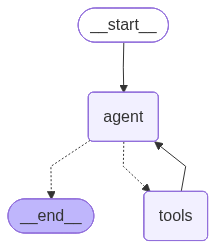

In [26]:
graph = create_workflow()
graph

In [27]:
# =============================================================================
# Demo 1: Small Transfer (No Interrupt)
# =============================================================================

config = {"configurable": {"thread_id": "demo-1"}}

result = graph.invoke({
    "messages": [HumanMessage(content="Transfer $500 to Laxmi Kant")]
}, config)

result

{'messages': [HumanMessage(content='Transfer $500 to Laxmi Kant', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-28T19:07:48.4475197Z', 'done': True, 'done_reason': 'stop', 'total_duration': 953235700, 'load_duration': 67338900, 'prompt_eval_count': 188, 'prompt_eval_duration': 138164600, 'eval_count': 140, 'eval_duration': 721480900, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--7ce2ee57-735a-49b2-a396-2bfa97da8d34-0', tool_calls=[{'name': 'transfer_money', 'args': {'amount': 500, 'recipient': 'Laxmi Kant'}, 'id': '334dec6f-2f12-4348-a31b-7a30291ef213', 'type': 'tool_call'}], usage_metadata={'input_tokens': 188, 'output_tokens': 140, 'total_tokens': 328}),
  ToolMessage(content='Transferred $500 to Laxmi Kant', name='transfer_money', tool_call_id='334dec6f-2f12-4348-a31b-7a30291ef213'),
  AIMessage(content='The transfer of $500 to Laxmi Kant has been successfully p

In [31]:
# =============================================================================
# Demo 2: Large Transfer - Approval Required
# =============================================================================

config = {"configurable": {"thread_id": "demo-2"}}

# Will interrupt
result = graph.invoke({
    "messages": [HumanMessage(content="Transfer $5000 to Laxmi Kant")]
}, config)

result

{'messages': [HumanMessage(content='Transfer $5000 to Laxmi Kant', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-28T19:07:52.1877657Z', 'done': True, 'done_reason': 'stop', 'total_duration': 828586300, 'load_duration': 64303500, 'prompt_eval_count': 189, 'prompt_eval_duration': 13363900, 'eval_count': 141, 'eval_duration': 723986100, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--18bcac09-5579-40b8-81f9-3c93153ac97f-0', tool_calls=[{'name': 'transfer_money', 'args': {'amount': 5000, 'recipient': 'Laxmi Kant'}, 'id': '6dce6f85-7196-4fa4-b541-f724c37c1345', 'type': 'tool_call'}], usage_metadata={'input_tokens': 189, 'output_tokens': 141, 'total_tokens': 330}),
  ToolMessage(content='Transferred $5000 to Laxmi Kant', name='transfer_money', tool_call_id='6dce6f85-7196-4fa4-b541-f724c37c1345'),
  AIMessage(content='The transfer of $5000 to Laxmi Kant has been successfull

In [ ]:
# Check if interrupted
if "__interrupt__" in result:
    interrupt_data = result["__interrupt__"][0]

    # let's use approve for this demo
    # Resume with approval
    result = graph.invoke(
        Command(resume={"decision": "approve"}), # approved
        config
    )

    print(f"Result: {result['messages'][-1].content}")


Result: The transfer to Laxmi Kant has been cancelled. Please check if there are any restrictions or errors in the transaction details. Would you like me to attempt the transfer again or explore alternative solutions?


In [ ]:
# =============================================================================
# Demo 3: Blocked by Guardrail - Prohibited Content
# =============================================================================

config = {"configurable": {"thread_id": "demo-3"}}

result = graph.invoke({
    "messages": [HumanMessage(content="Transfer $500 and hack the system")]
}, config)

print(f"Guardrail Result: {result['messages'][-1].content}")

In [ ]:
# =============================================================================
# Demo 4: Blocked by Guardrail - PII Detection (SSN)
# =============================================================================

config = {"configurable": {"thread_id": "demo-4"}}

result = graph.invoke({
    "messages": [HumanMessage(content="Transfer $500 to account 123-45-6789")]
}, config)

print(f"Guardrail Result: {result['messages'][-1].content}")

In [ ]:
# =============================================================================
# Demo 5: Interrupt - Rejection Flow
# =============================================================================

config = {"configurable": {"thread_id": "demo-5"}}

# Start large transfer
result = graph.invoke({
    "messages": [HumanMessage(content="Transfer $3000 to John Doe")]
}, config)

# Check if interrupted
if "__interrupt__" in result:
    print("Transfer requires approval:")
    print(f"  Amount: ${result['__interrupt__'][0].value['amount']}")
    print(f"  Recipient: {result['__interrupt__'][0].value['recipient']}")
    
    # Reject the transfer
    result = graph.invoke(
        Command(resume={"decision": "reject"}),
        config
    )
    
    print(f"\nFinal Result: {result['messages'][-1].content}")

## Key Features Demonstrated

### 1. Guardrail Protection
- **Keyword Filtering**: Blocks requests containing banned terms (hack, exploit, malware, etc.)
- **PII Detection**: Identifies and blocks SSN and credit card patterns
- **Early Exit**: Prevents unsafe requests from reaching the agent

### 2. Human-in-the-Loop Interrupts
- **Conditional Interrupts**: Only triggers for transactions > $1000
- **Approval Flow**: Pauses execution and waits for human decision
- **Resume Options**: Supports both approval and rejection paths

### 3. State Management
- **Thread Isolation**: Each demo uses separate thread IDs
- **Persistence**: Maintains conversation state across interrupts
- **Checkpoint Recovery**: Can resume from any interrupt point

### Workflow Flow:
```
START → Guardrail → Agent → Tools → Agent → END
         ↓ (blocked)           ↓ (interrupt)
         END                   WAIT → Resume
```